In [1]:
import torch

import torch.nn as nn

#from nvae.utils import add_sn
#from nvae.vae_celeba import NVAE
import numpy as np
import matplotlib.pyplot as plt
#from nvae.utils import reparameterize


In [2]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

from vae import VAE_big

model = VAE_big(device, image_channels=3).to(device)

train_data_size = 162079
epochs = 199



#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))


#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))


#model.eval()

# VAE plots

Young men selected segment 29

Od men selecte segment 0

Young women segment 5

Old women segment 15

# For Venilla VAE minimum and maximum damages of the group

## Min and max segments choosen from Vanilla VAE

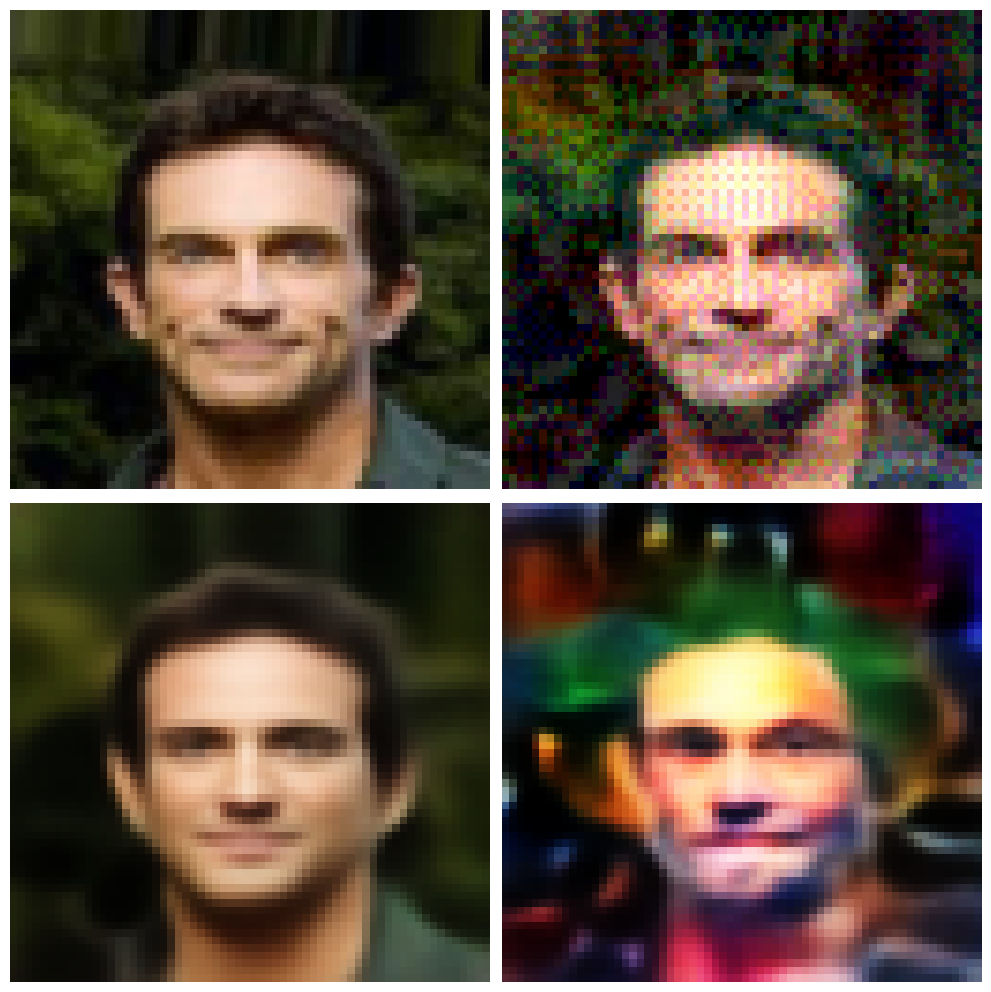

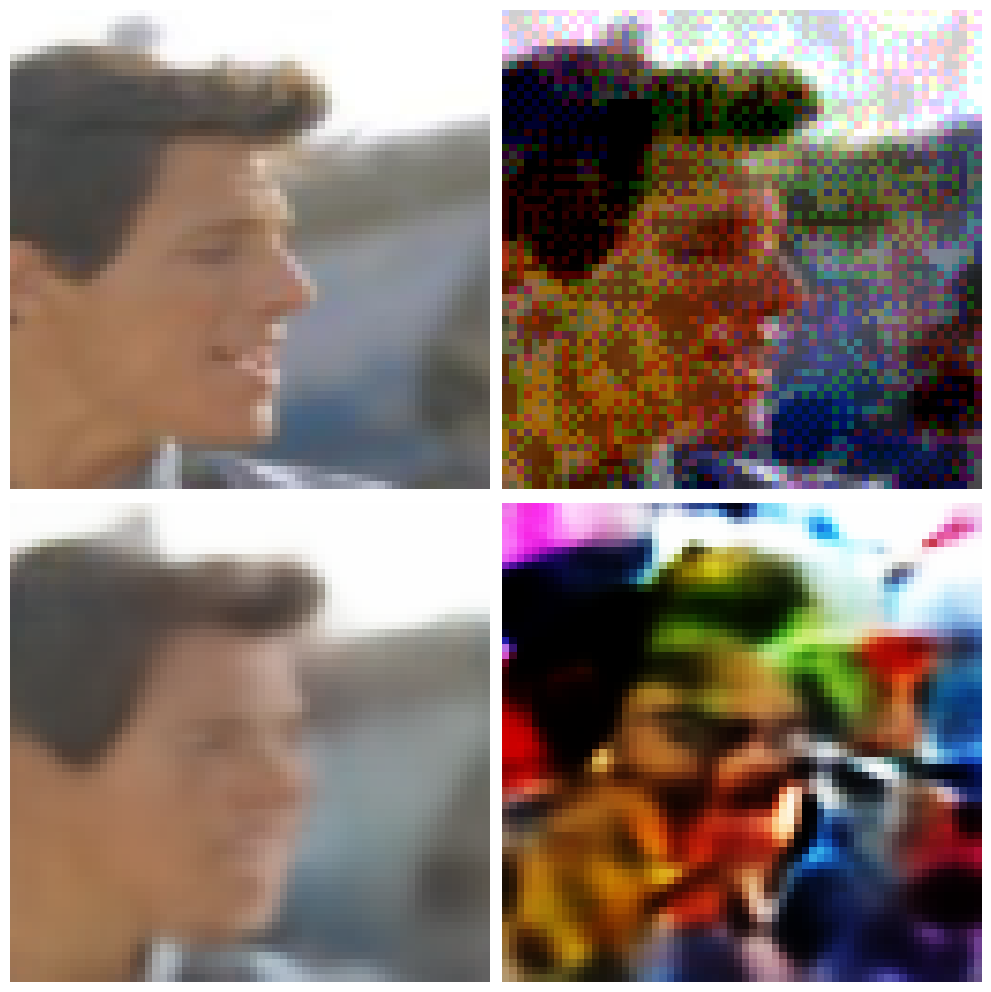

In [3]:
# 0
#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
#model.eval()

#segment = 14

beta_value = 1.0

prev_div_min = 100.0
prev_div_max = 0.0

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = all_features[0]

for segment in range(60):
    desired_norm_l_inf = 0.094

    #all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

    universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

    source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
    #optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

    if(beta_value == 5.0 or beta_value == 10.0): 
        model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
    else:
        model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
    model.eval()


    image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
    aspect_ratio = image_width / image_height

    corresponding_class_polulations = [1819, 24707, 145, 2827]
    #inside_feature_name = inside_feature_names[3]



    actualOutput, _, _ = model(source_im)
    ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


    DivAttackeImage = source_im + optimized_noise
    NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
    DivOutput,_,_ = model(NormalDivAttackeImage)
    DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

    #print("DivOutputL2ActualOutput", DivOutputL2ActualOutput)
    if(DivOutputL2ActualOutput<prev_div_min):
        prev_div_min = DivOutputL2ActualOutput
        min_segment = segment
    if(DivOutputL2ActualOutput>prev_div_max):
        prev_div_max = DivOutputL2ActualOutput
        max_segment = segment


# 0
segment = min_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()



segment = max_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
#optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 

if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()




# Carrying on the mimimum and maximum damaged images in higher beta variants including 10.0 and 5.0

# beta value 5.0

## Min and max segments choosen from Vanilla VAE

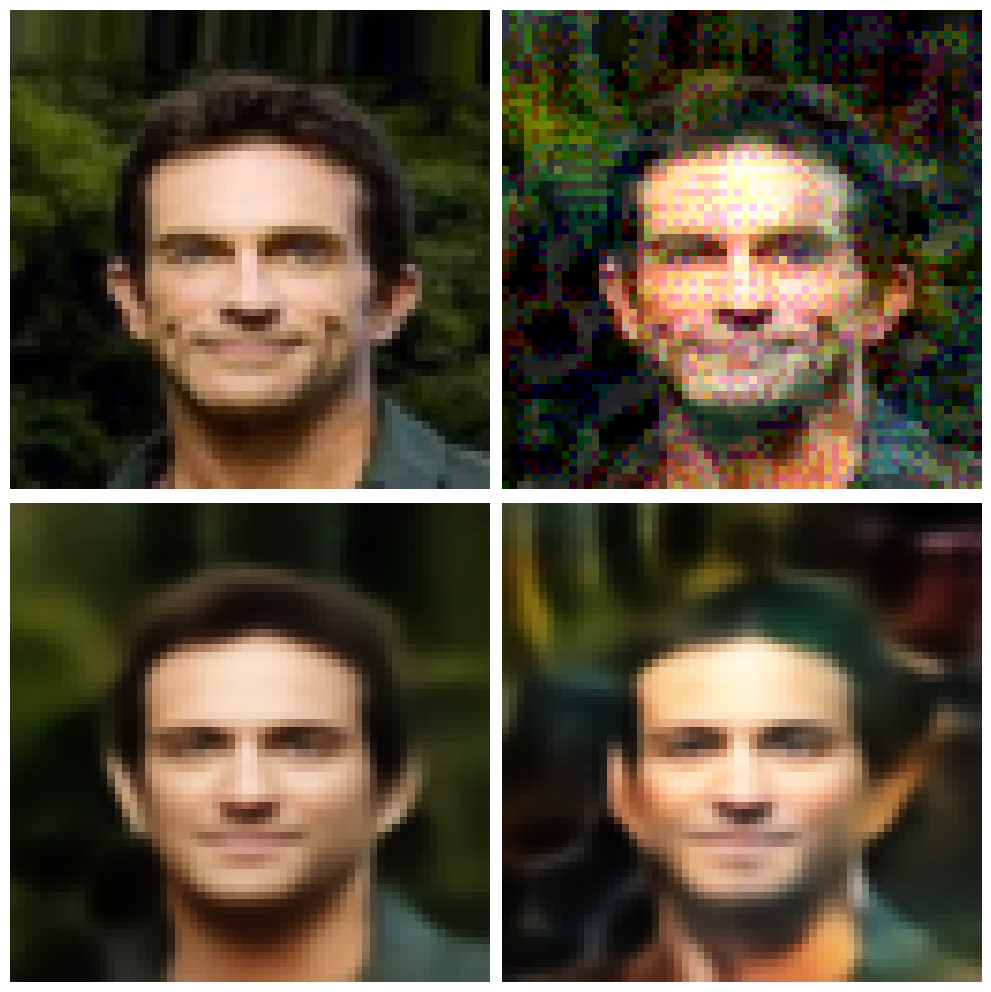

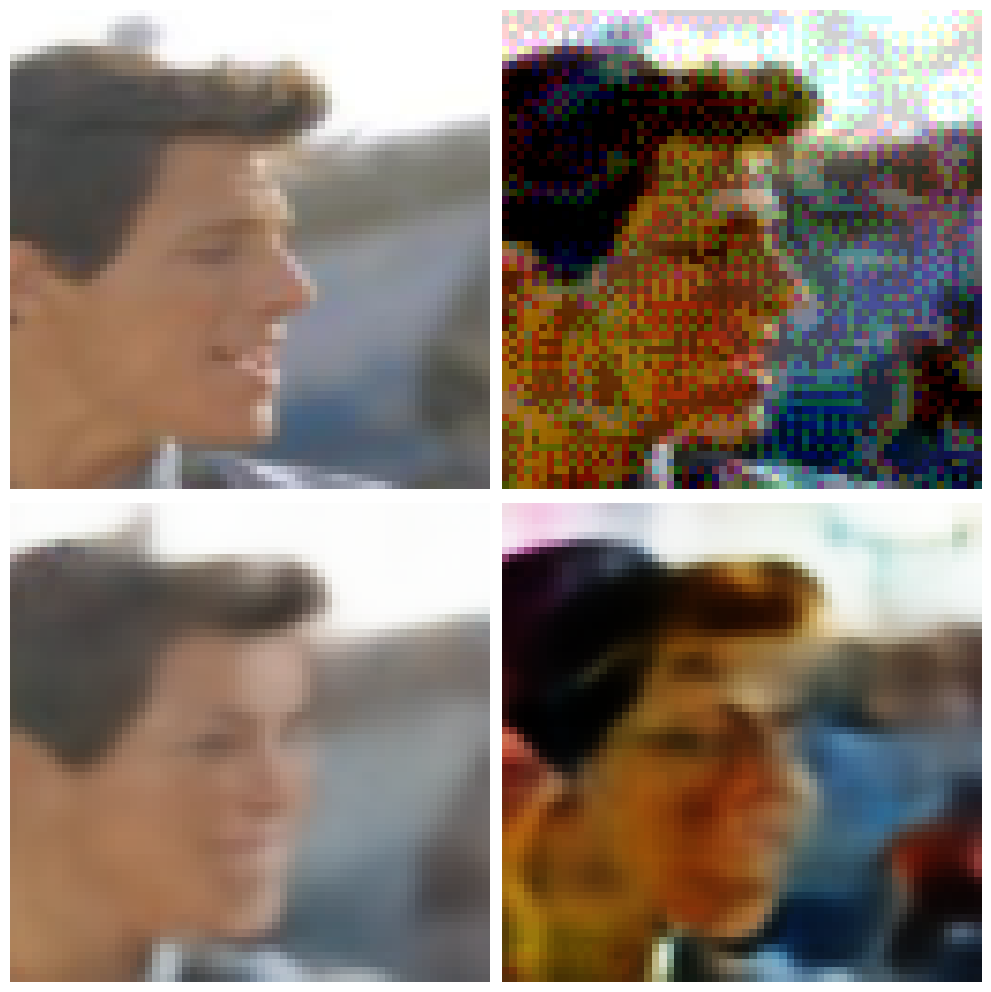

In [4]:
beta_value = 5.0
#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

#model.eval()


segment = min_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()



segment = max_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()




# Beta value 10.0

## Min and max segments choosen from Vanilla VAE

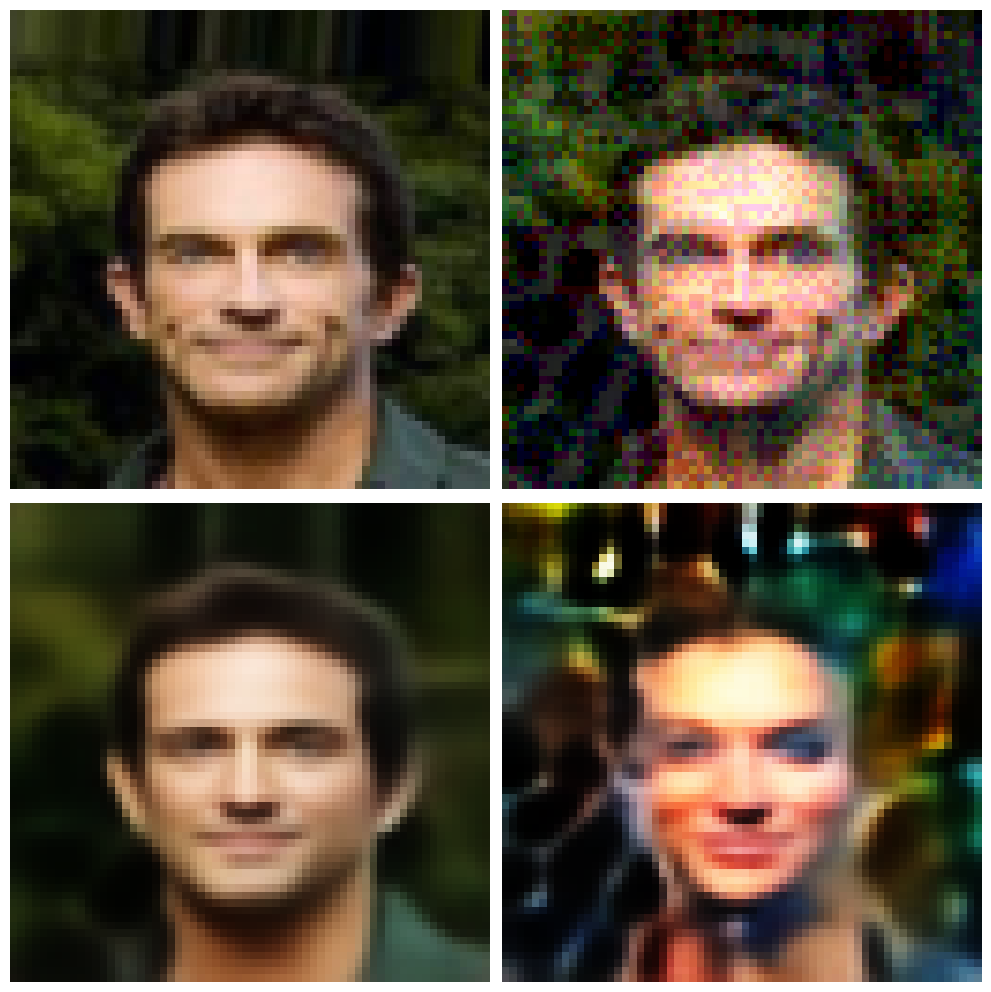

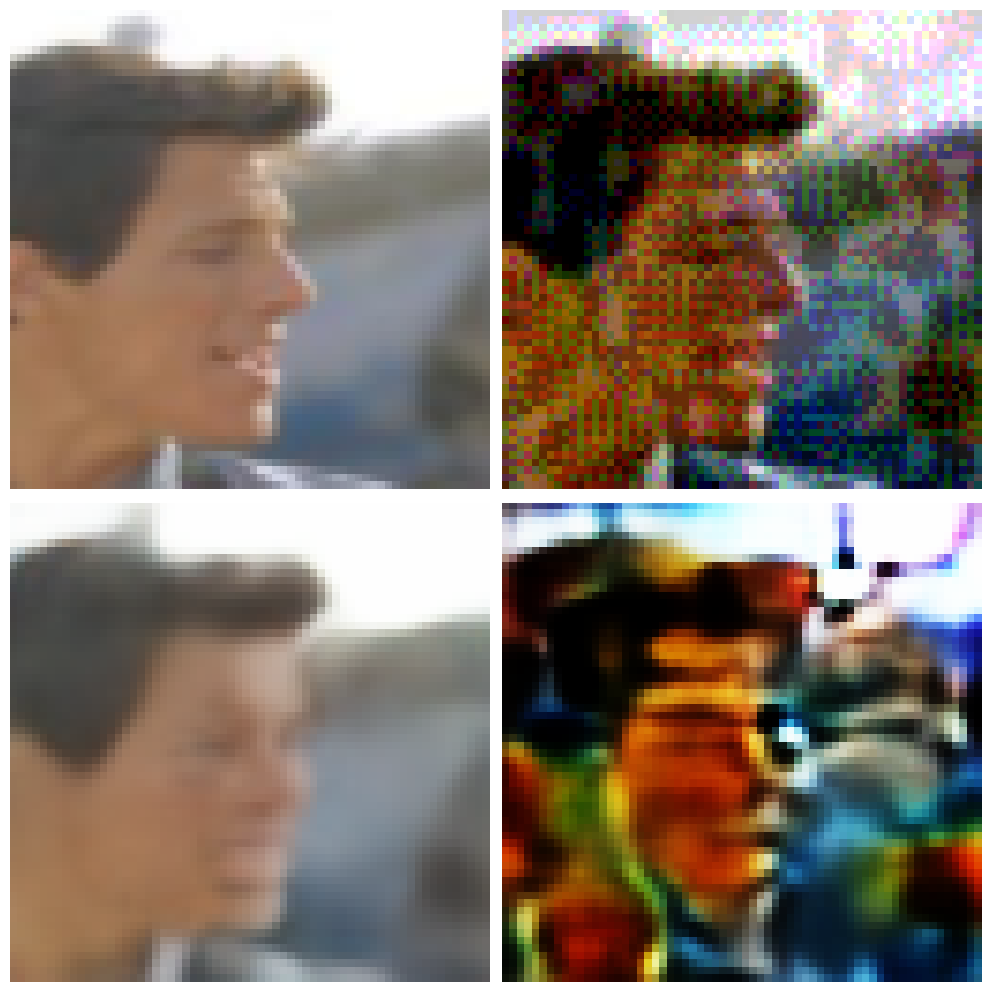

In [5]:
beta_value = 10.0
#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

#model.eval()


segment = min_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()



segment = max_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
#feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()




# For Beta VAE with Beta  = 5.0 min and maximum damaged images

## Your VAE specific min and max segments

In [6]:
feature = all_features[0]


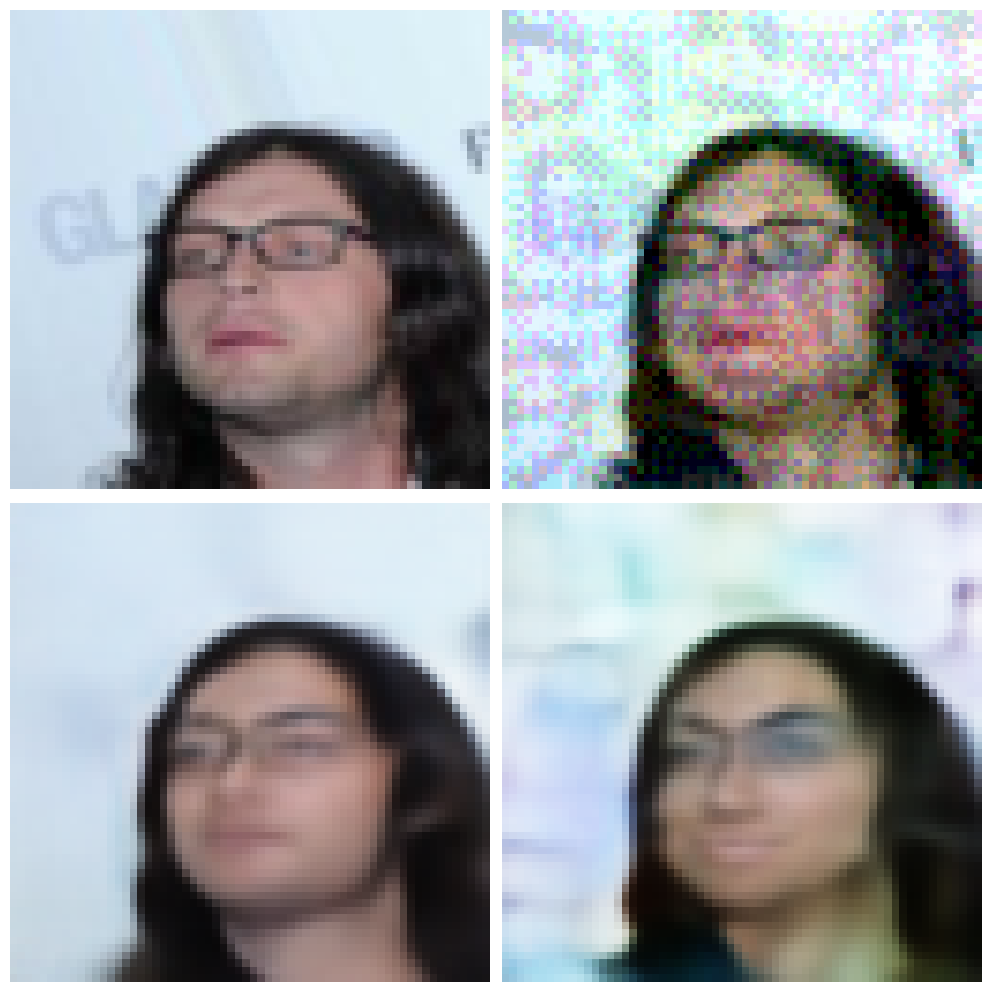

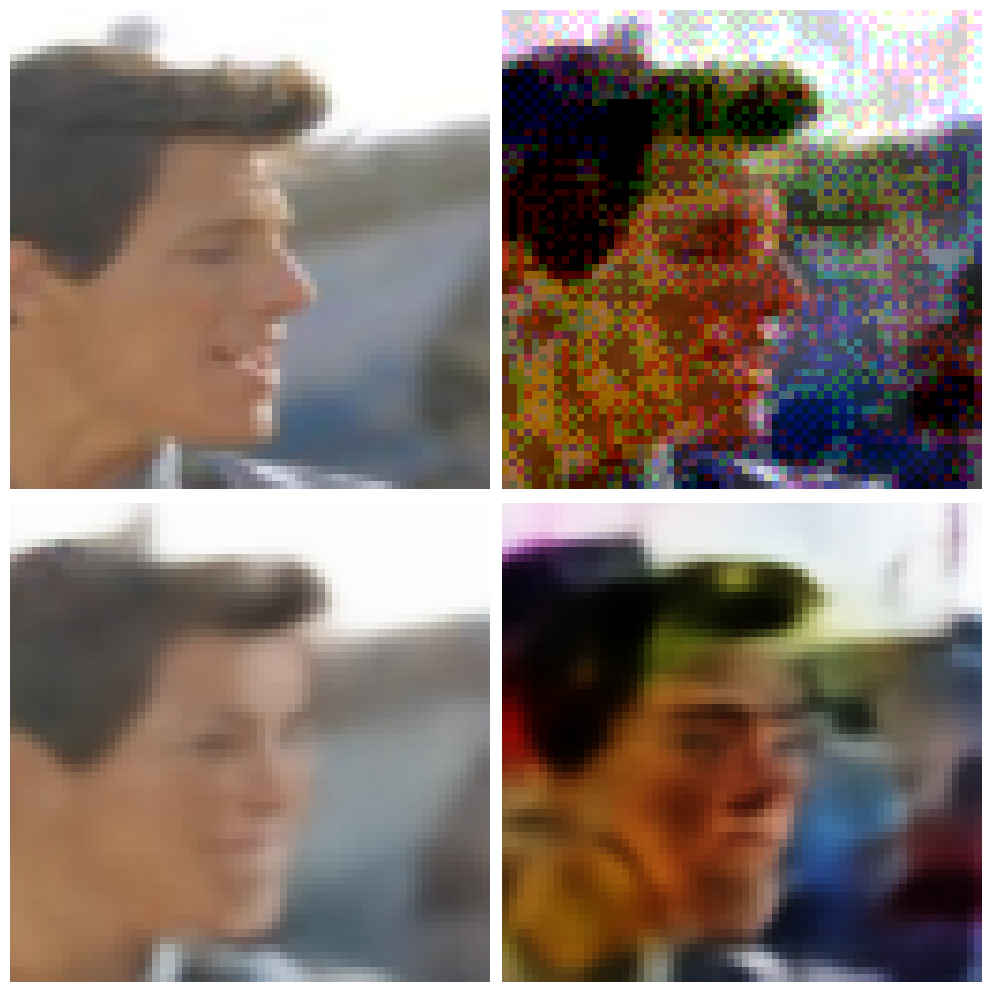

In [7]:
# 0
beta_value = 5.0
#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

model.eval()

#segment = 14
prev_div_min = 100.0
prev_div_max = 0.0
for segment in range(60):
    desired_norm_l_inf = 0.094

    #all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

    universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

    all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
    #feature = all_features[0]

    source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
    if(beta_value == 5.0 or beta_value == 10.0): 
        model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
    else:
        model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
        optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
    model.eval()


    image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
    aspect_ratio = image_width / image_height

    corresponding_class_polulations = [1819, 24707, 145, 2827]
    #inside_feature_name = inside_feature_names[3]



    actualOutput, _, _ = model(source_im)
    ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


    DivAttackeImage = source_im + optimized_noise
    NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
    DivOutput,_,_ = model(NormalDivAttackeImage)
    DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

    #print("DivOutputL2ActualOutput", DivOutputL2ActualOutput)
    if(DivOutputL2ActualOutput<prev_div_min):
        prev_div_min = DivOutputL2ActualOutput
        min_segment = segment
    if(DivOutputL2ActualOutput>prev_div_max):
        prev_div_max = DivOutputL2ActualOutput
        max_segment = segment


# 0
segment = min_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()



segment = max_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()




# For beta VAE with Beta = 10.0 with minimum and maximum damaged images

## Your VAE specific min and max segments

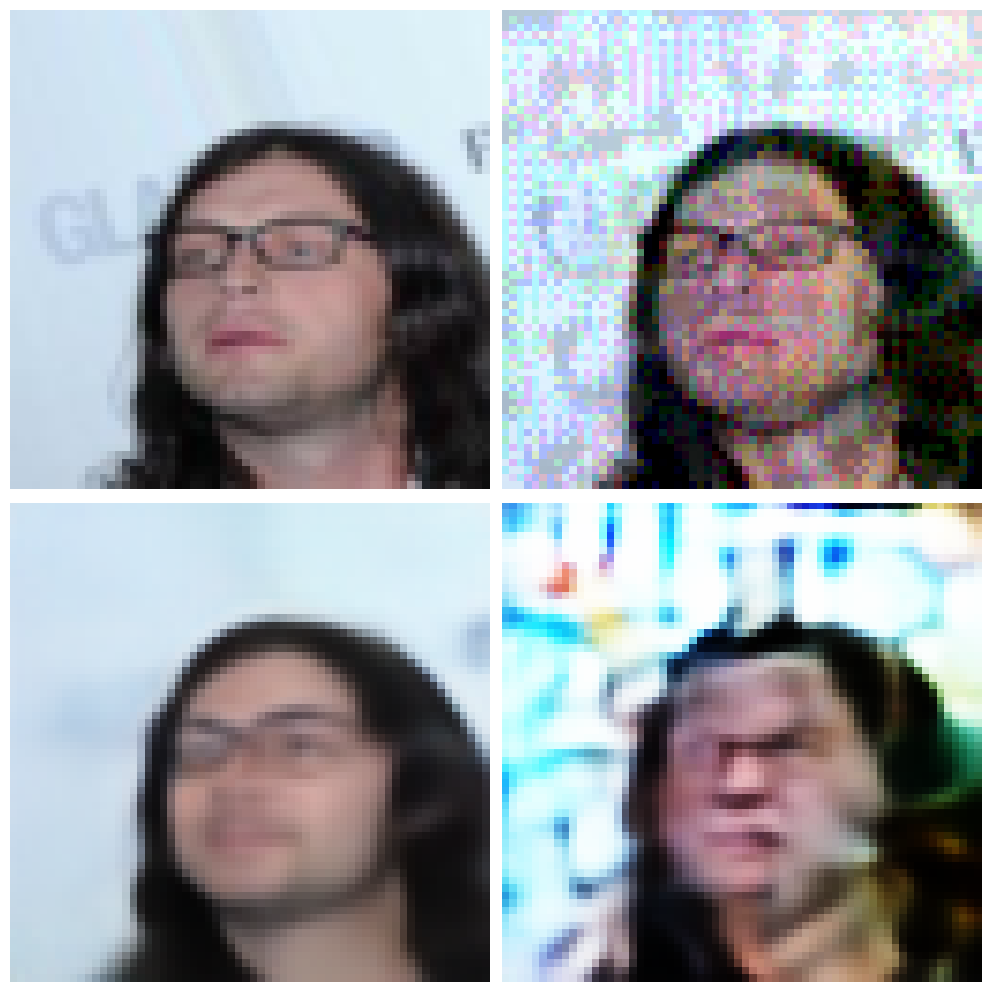

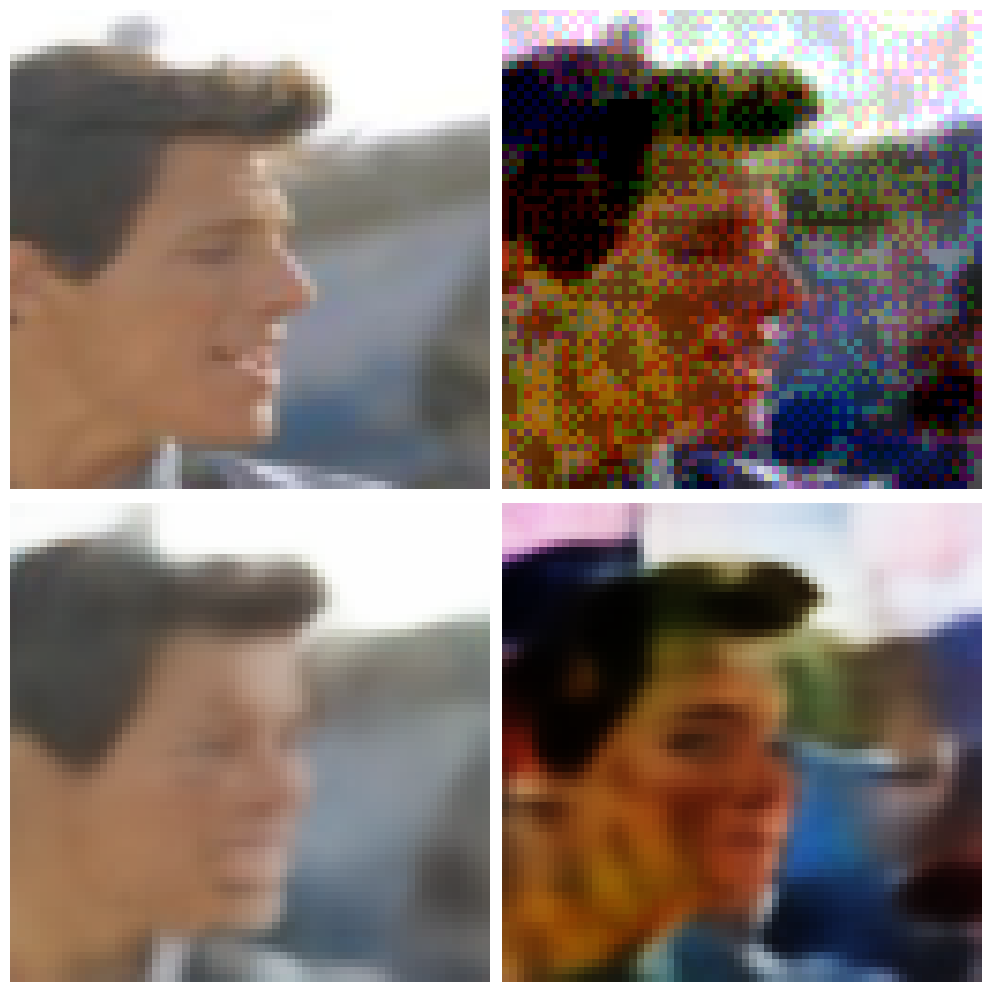

In [8]:
# 0
beta_value = 10.0
model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

model.eval()

#segment = 14
prev_div_min = 100.0
prev_div_max = 0.0
for segment in range(60):
    desired_norm_l_inf = 0.094

    #all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

    universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

    all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
    #feature = all_features[0]

    source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



    image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
    aspect_ratio = image_width / image_height

    corresponding_class_polulations = [1819, 24707, 145, 2827]
    #inside_feature_name = inside_feature_names[3]



    actualOutput, _, _ = model(source_im)
    ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


    DivAttackeImage = source_im + optimized_noise
    NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
    DivOutput,_,_ = model(NormalDivAttackeImage)
    DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

    #print("DivOutputL2ActualOutput", DivOutputL2ActualOutput)
    if(DivOutputL2ActualOutput<prev_div_min):
        prev_div_min = DivOutputL2ActualOutput
        min_segment = segment
    if(DivOutputL2ActualOutput>prev_div_max):
        prev_div_max = DivOutputL2ActualOutput
        max_segment = segment


# 0
segment = min_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()



segment = max_segment

desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 



image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()




# Beta VAE plots for chosen segments of images

In [92]:
segment = 0


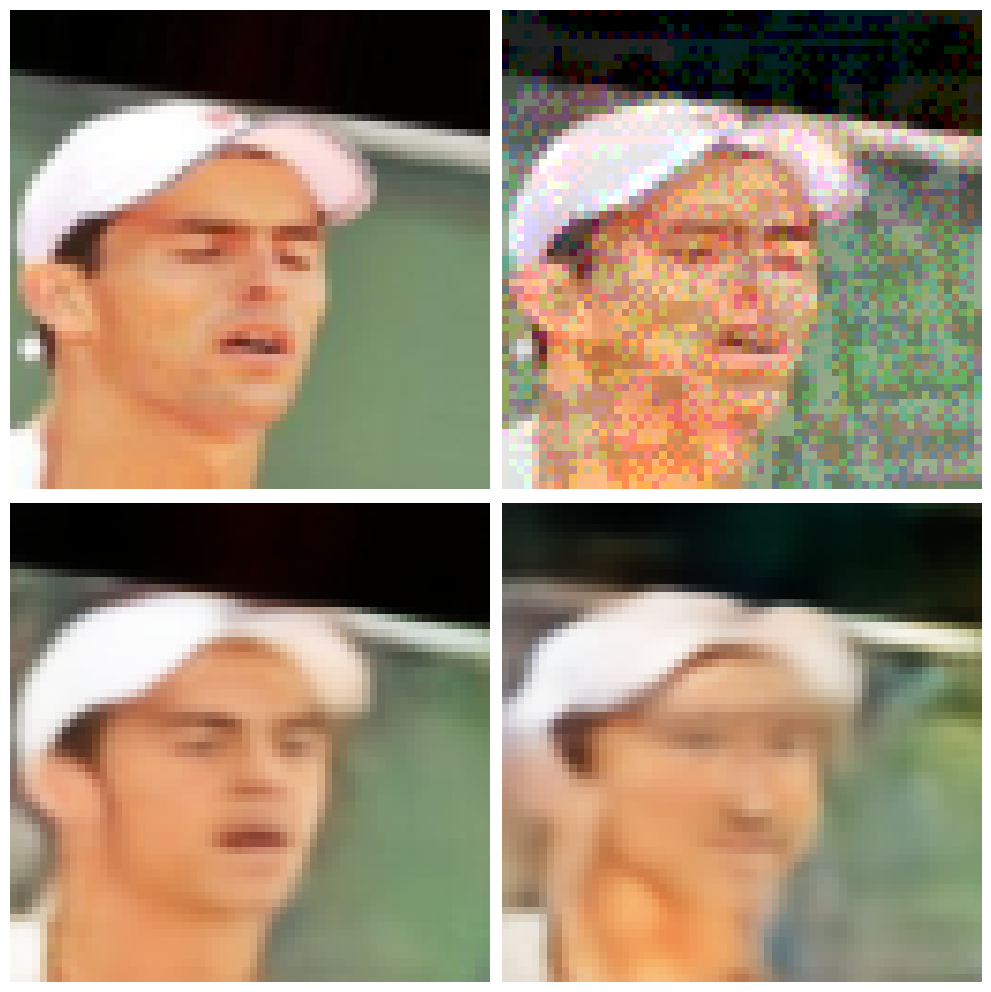

feature youngmen
segment 4


In [97]:
beta_value = 5.0
#model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))

#model.eval()



desired_norm_l_inf = 0.094

#all_features = ["bald", "beard", "oldfemaleGlass", "hat"]#, "generalWhiteWomen", "blackWomen"]

universal_features_list = ["bald", "beard", "oldfemaleGlass", "hat", "blackWomen", "generalWhiteWomen", "blackMen", "generalWhiteMen", "men", "women", "young", "old", "youngmen", "oldmen", "youngwomen", "oldwomen" ]

all_features = ["youngmen", "oldmen", "youngwomen", "oldwomen"]
feature = all_features[0]

source_im = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/images.pt")[segment].unsqueeze(0).to(device) 
if(beta_value == 5.0 or beta_value == 10.0): 
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE'+str(beta_value)+'_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"beta"+str(beta_value)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
else:
    model.load_state_dict(torch.load('/home/luser/autoencoder_attacks/saved_celebA/checkpoints/celebA_CNN_VAE_big_trainSize'+str(train_data_size)+'_epochs'+str(epochs)+'.torch'))
    optimized_noise = torch.load("/home/luser/autoencoder_attacks/train_aautoencoders/fairness_trials/attack_saves/"+str(feature)+"_d/"+str(feature)+"_scaled_noise_"+str(desired_norm_l_inf)+"segment"+str(segment)+".pt", map_location=device).to(device) 
model.eval()


image_height, image_width, _ = source_im[0].cpu().detach().permute(1, 2, 0).cpu().numpy().shape
aspect_ratio = image_width / image_height

corresponding_class_polulations = [1819, 24707, 145, 2827]
#inside_feature_name = inside_feature_names[3]



actualOutput, _, _ = model(source_im)
ActualReconLoss = torch.sqrt((actualOutput - source_im)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()


DivAttackeImage = source_im + optimized_noise
NormalDivAttackeImage = (DivAttackeImage - DivAttackeImage.min())/(DivAttackeImage.max() - DivAttackeImage.min())
DivOutput,_,_ = model(NormalDivAttackeImage)
DivOutputL2ActualOutput = torch.sqrt((DivOutput - actualOutput)**2).mean(dim=(1, 2, 3), keepdim=True).squeeze()

model.eval()
with torch.no_grad():
    image_recon, recon_loss, kl_losses = model(source_im)

    fig, ax = plt.subplots(2, 2, figsize=(10, 10/ aspect_ratio))
    ax[0][0].imshow(source_im[0].permute(1, 2, 0).cpu().numpy())
    #ax[0].set_title('Original Image')
    ax[0][0].axis('off')

    ax[1][0].imshow(actualOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[1].set_title('Actual Reconstructed Image')
    ax[1][0].axis('off')

    ax[0][1].imshow(NormalDivAttackeImage[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[2].set_title('Adversarial Image')
    ax[0][1].axis('off')

    ax[1][1].imshow(DivOutput[0].cpu().detach().permute(1, 2, 0).cpu().numpy())
    #ax[3].set_title('Adversarial Reconstructed Image')
    ax[1][1].axis('off')
plt.tight_layout(pad=1)
#plt.savefig("/home/luser/autoencoder_attacks/a_fairness_results/qualitative_comparision/BetaVAE_qualitative_"+str(feature)+"im_no_"+str(segment)+".png")
plt.show()

print("feature", feature)
print("segment", segment)
segment += 1


